<a href="https://colab.research.google.com/github/luciaemiliaeu/netflix_data_analysis/blob/main/netflix_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

## Base de dados

In [2]:
url = "https://raw.githubusercontent.com/luciaemiliaeu/netflix_data_analysis/main/ViewingActivity.csv"

In [3]:
dataset = pd.read_csv(url, usecols=['Profile Name', 'Start Time', 'Duration', 'Title', 'Supplemental Video Type'] )

In [4]:
dataset.head()

,Profile Name,Start Time,Duration,Title,Supplemental Video Type
0,Lúcia Emília,2020-11-16 21:09:01,00:20:00,Friends: Temporada 5: Aquele com a garota que ...,NaN
1,Lúcia Emília,2020-11-16 20:46:50,00:22:09,Friends: Temporada 5: Aquele em que todos fica...,NaN
2,Socorro Soares,2020-11-16 20:27:12,00:43:07,Jurassic World: Reino Ameaçado,NaN
3,Lúcia Emília,2020-11-16 20:24:42,00:22:06,Friends: Temporada 5: Aquele com a bolsa do Jo...,NaN
4,Lúcia Emília,2020-11-16 20:02:31,00:22:09,Friends: Temporada 5: Aquele com a risada de t...,NaN


## Pré-processamento

### Filtrando linhas onde o usuário sou eu e o conteúdo é série ou filme.

Isso exclui os outros usuário e conteúdos como trailer.

In [5]:
dataset = dataset[(dataset['Profile Name'] == 'Lúcia Emília') & (dataset['Supplemental Video Type'].isna())]
dataset.drop('Supplemental Video Type', axis=1 , inplace=True)
dataset.reset_index(inplace=True, drop=True)

In [6]:
dataset.drop('Profile Name', axis=1, inplace=True)

### Formatando as colunas de datas

Convertendo para o TimeZone do Brasil

In [7]:
dataset['Start Time'] = pd.DatetimeIndex(pd.to_datetime(dataset['Start Time'], utc=True)).tz_convert('America/Fortaleza')

Criando colunas: 
- *Duration* : duração do acesso em minutos (float)
- *End Time* : horário do término do acesso (datetime)


In [8]:
dataset['Duration'] = pd.to_timedelta(dataset['Duration'])
dataset['End Time'] = dataset['Start Time'] + dataset['Duration']
dataset['Duration'] = dataset['Duration'].apply(lambda x: x.seconds/60)

Criando colunas: 
- *Weekday*: dia da semana (0: Segunda - 6: Domingo)
- *Date* : data (YYYY-mm-dd)
- *Time* : horário (HH:mm:ss)

In [9]:
weekdays = {0: 'Segunda', 1: 'Terça', 2: 'Quarta', 3: 'Quinta', 4: 'Sexta', 5: 'Sábado', 6: 'Domingo'}

In [10]:
dataset['Weekday'] = dataset['Start Time'].dt.dayofweek
dataset['Date'] = dataset['Start Time'].dt.date
dataset['Time'] = dataset['Start Time'].dt.time

Reorganizando as colunas da tabela

In [11]:
dataset = dataset.reindex(['Start Time', 'End Time', 'Duration', 'Date', 'Weekday','Time', 'Title' ], axis=1)

### Filtando episódios realmente assitidos

Cosiderando o tempo mínimo de tela de 5 min por sessão

In [12]:
dataset.drop(dataset[dataset['Duration']<5].index, inplace=True)

### Separando as informações: Título, Temporada e Episódio em colunas 

Case seja filme, as colunas **Temporada** e **Episódio** ficarão com *None*

In [13]:
def identificando_series(title):
  title_, season, episode = None, None, None

  title_braked = title.split(':')
  # se for filme, só vai ter título ou título e subtítulo
  if len(title_braked) == 1 :
    title_ = title_braked[0]
  elif len(title_braked) == 2 :
    title_ = title_braked[0] + title_braked[1]

  # tratando subtítulo no episódio ou no nome da série
  elif len(title_braked) > 3: 
    if ((title_braked[0] == 'Gilmore Girls' and title_braked[1] ==' Tal Mãe, Tal Filha') 
      or (title_braked[0] == 'Gilmore Girls' and title_braked[1] ==' Um Ano para Recordar')
      or (title_braked[0] == 'Stranger Things' and title_braked[1] ==' Stranger Things 2')
      or (title_braked[0] == 'Jo Frost' and title_braked[1] ==' Babá em Turnê')):
      title_ = title_braked[0] + title_braked[1]
      season = title_braked[2]
      episode = title_braked[3]
    else: 
      title_ = title_braked[0]
      season = title_braked[1]
      episode = title_braked[2] + title_braked[3]
    return [title_, season, episode]
  
  else:
    title_ = title_braked[0]
    season = title_braked[1]
    episode = title_braked[2]
  
  return pd.Series([title_, season, episode])

dataset[['Titulo', 'Temporada', 'Episodio']] = dataset.apply(lambda x: identificando_series(x.Title), axis=1 )
dataset.drop('Title', axis=1, inplace=True)

### DataFrame final

In [14]:
dataset.head()

,Start Time,End Time,Duration,Date,Weekday,Time,Titulo,Temporada,Episodio
0,2020-11-16 18:09:01-03:00,2020-11-16 18:29:01-03:00,20.00,2020-11-16,0,18:09:01,Friends,Temporada 5,Aquele com a garota que bate no Joey (Episódi...
1,2020-11-16 17:46:50-03:00,2020-11-16 18:08:59-03:00,22.15,2020-11-16,0,17:46:50,Friends,Temporada 5,Aquele em que todos ficam sabendo (Episódio 14)
2,2020-11-16 17:24:42-03:00,2020-11-16 17:46:48-03:00,22.10,2020-11-16,0,17:24:42,Friends,Temporada 5,Aquele com a bolsa do Joey (Episódio 13)
3,2020-11-16 17:02:31-03:00,2020-11-16 17:24:40-03:00,22.15,2020-11-16,0,17:02:31,Friends,Temporada 5,Aquele com a risada de trabalho do Chandler (...
4,2020-11-16 16:41:01-03:00,2020-11-16 17:02:28-03:00,21.45,2020-11-16,0,16:41:01,Friends,Temporada 5,Aquele com todas as resoluções (Episódio 11)


In [15]:
dataset.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6389 entries, 0 to 8052
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype                            
---  ------      --------------  -----                            
 0   Start Time  6389 non-null   datetime64[ns, America/Fortaleza]
 1   End Time    6389 non-null   datetime64[ns, America/Fortaleza]
 2   Duration    6389 non-null   float64                          
 3   Date        6389 non-null   object                           
 4   Weekday     6389 non-null   int64                            
 5   Time        6389 non-null   object                           
 6   Titulo      6389 non-null   object                           
 7   Temporada   6241 non-null   object                           
 8   Episodio    6241 non-null   object                           
dtypes: datetime64[ns, America/Fortaleza](2), float64(1), int64(1), object(5)
memory usage: 499.1+ KB


O dataset final tem 6389 amostras e 9 colunas. 

Apenas as amostras com filmes têm valores nulos nas colunas *Temporada* e *Episodio*.

## Análises

### Tempo total gasto assistindo Netflix

In [16]:
minutos = dataset['Duration'].sum()
horas = minutos/60
dias = horas/24
print('{} dias {} horas e {} minutos'.format(int(dias), 
                                int(horas)-24*int(dias),
                                int(minutos)-60*(24*int(dias) + (int(horas)-24*int(dias)))
                                ))

116 dias 1 horas e 45 minutos


### Frequência de uso da netflix por data

Contabilizando os minutos assistidos por dia

In [17]:
by_date = dataset.groupby(dataset['Date']).sum()['Duration']

Considerando os dias em que a contagem foi zero.

In [18]:
min_date, max_date = dataset['Date'].min(), dataset['Date'].max()
all_dates = pd.date_range(start = min_date, end = max_date)
dt = pd.Series(data = np.zeros(all_dates.shape[0]), index = all_dates, name = 'Duration' )

In [19]:
dt = pd.merge(dt, by_date, how='left', left_index=True, right_index= True)
dt['Duration'] = dt['Duration_x'] + dt['Duration_y']
dt = (dt.
      drop(['Duration_x', 'Duration_y'], axis=1).
      fillna(0).
      reset_index())
dt['Weekday'] = dt['index'].dt.dayofweek

Formatando os labels do gráfico

In [20]:
dt['labels'] = dt['index'].dt.to_period('M')
index_labels = dt['labels'].searchsorted(dt['labels'].unique())
dt.drop('labels', axis=1, inplace=True)

y = [100,200,300,400,500,600,700,800]
horas = [str(int(x/60)) for x in y]
minutos = [str(int(x%60)) for x in y]
ylabels = list(zip(horas, minutos))
ylabels = [hora[0]+':'+hora[1] for hora in ylabels]

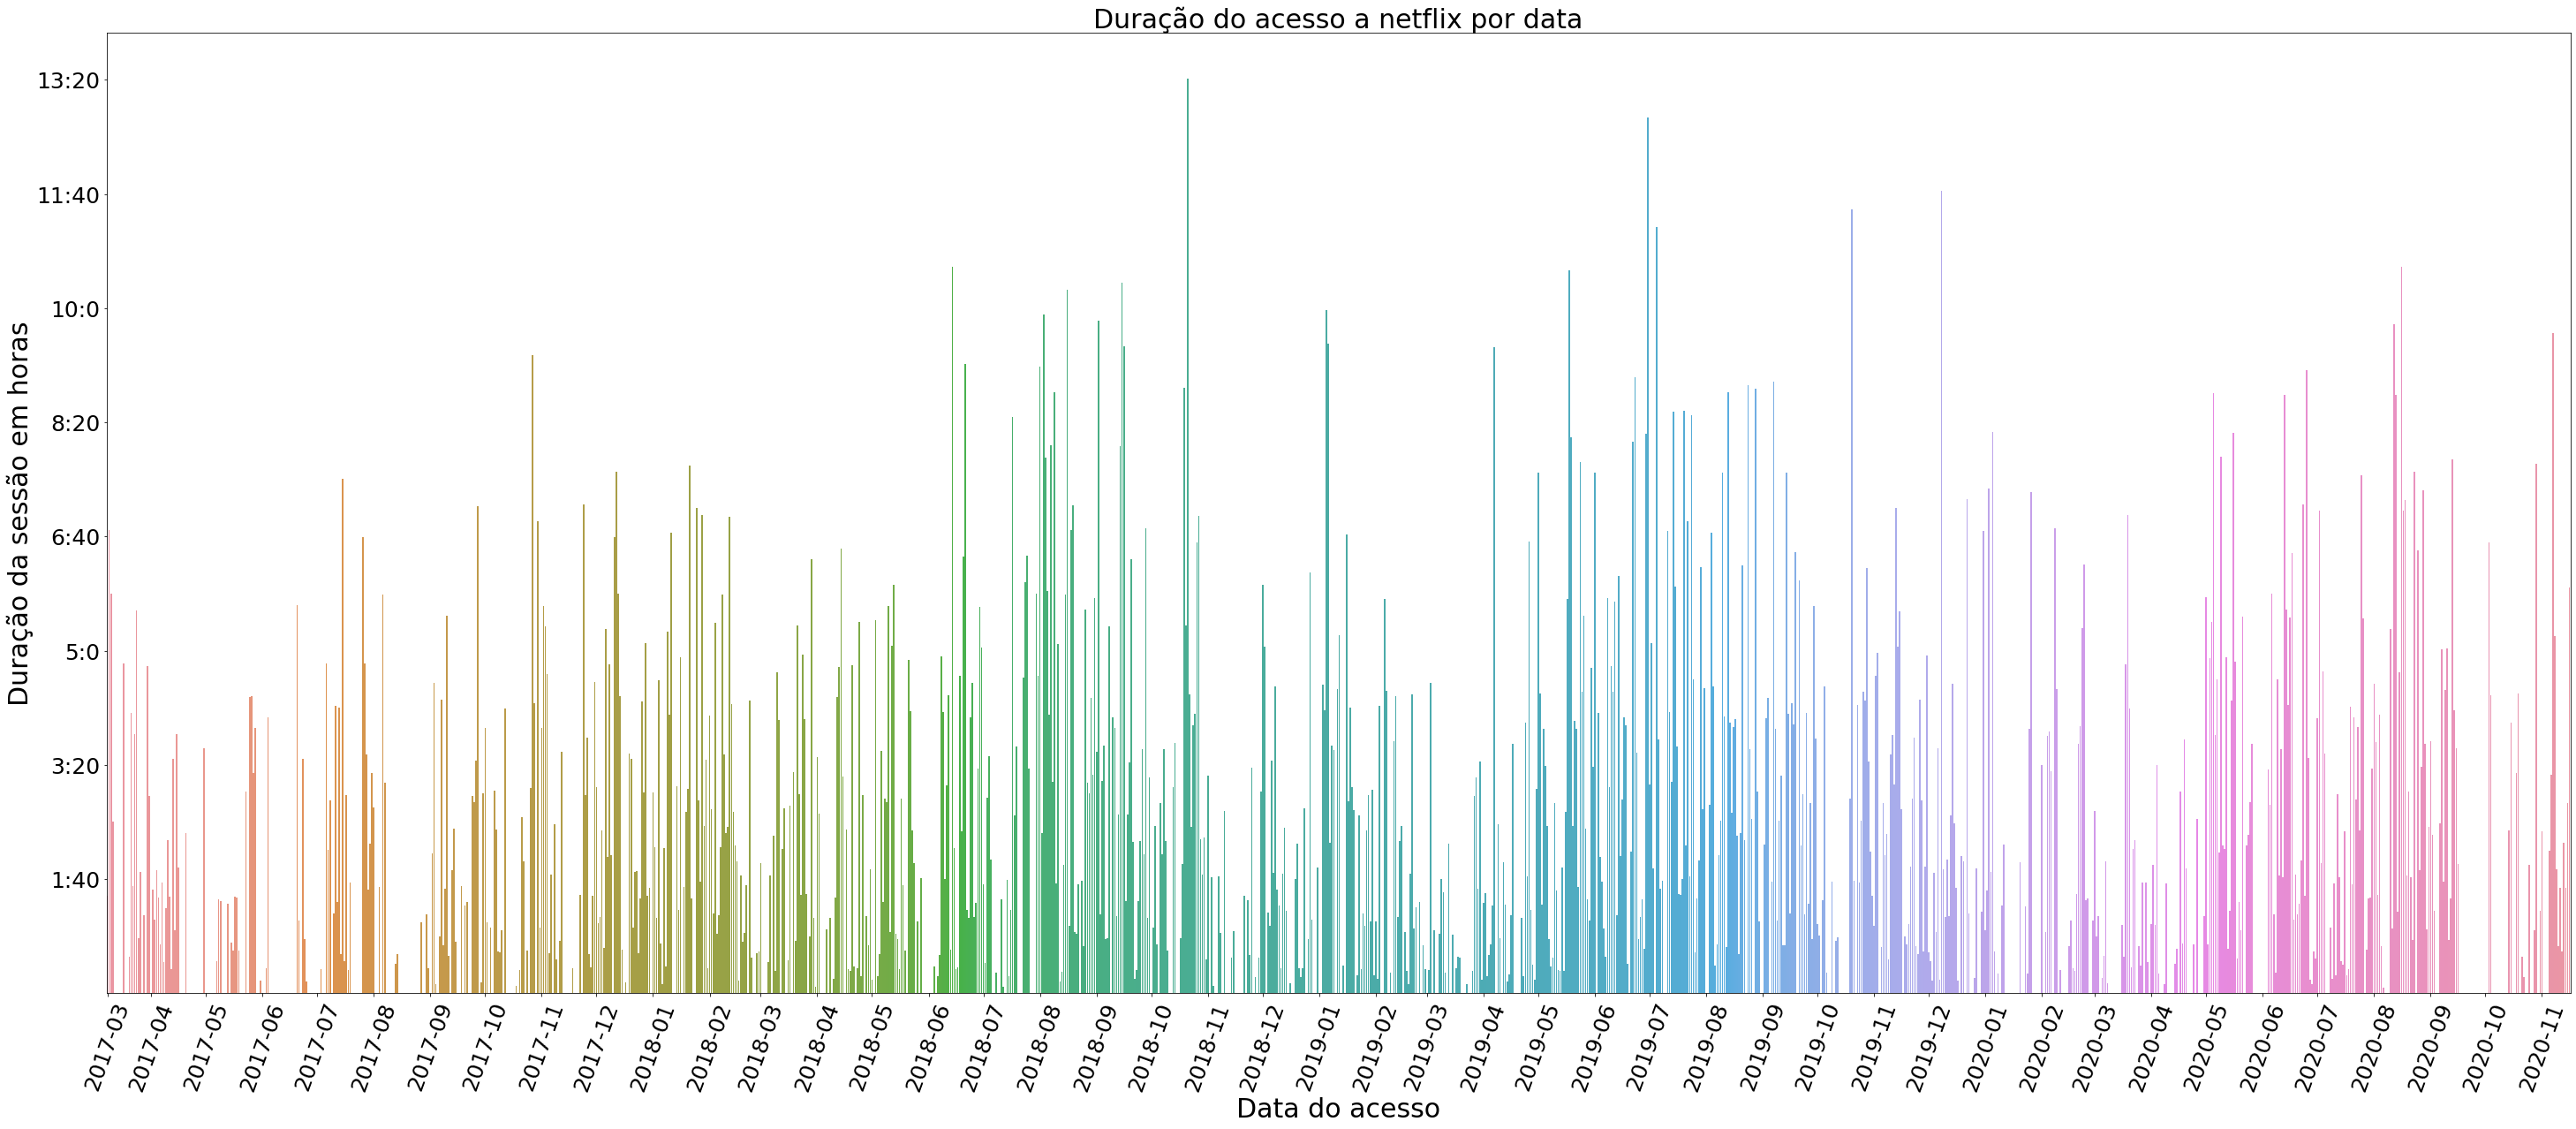

In [21]:
figure = plt.figure(figsize=(50,20))
sns.barplot(x='index', y = 'Duration', data=dt)
plt.xticks(index_labels, dt.loc[index_labels, 'index'].dt.to_period('M'), 
           rotation = 70, fontsize=25)
plt.yticks(y, ylabels, fontsize=25)
plt.xlabel('Data do acesso', fontsize=30)
plt.ylabel('Duração da sessão em horas', fontsize=30)
plt.title('Duração do acesso a netflix por data', fontsize=30)
plt.show()

De acordo com o gráfico, nenhum padrão foi identificado relacionando a quantidade de horas assistidas e períodos de tempo.

Contudo, alguns picos foram identificados.

### Verificando os acessos de maior duração

In [22]:
max_acessos = dt.sort_values('Duration', ascending=False).head(10)['index'].dt.date
max_acessos = (dataset[dataset['Date'].isin(max_acessos)].
               groupby(['Date', 'Weekday', 'Titulo'])['Duration'].
               agg({'sum'}))
max_acessos.loc[:, 'sum'] = max_acessos.apply(lambda x: str(int(x['sum']/60))+':'+str(int(x['sum']%60)), axis=1)
max_acessos.columns = ['Duration']
max_acessos

Duration
Date       Weekday Titulo                                   
2018-06-14 3       A Anatomia de Grey                   5:18
                   Everything Sucks!                    1:13
                   Friends                              1:30
                   Gilmore Girls Tal Mãe, Tal Filha     0:10
                   Guardiões da Galáxia                  0:7
                   Os Vingadores - The Avengers         2:16
2018-08-16 3       A Anatomia de Grey                  10:15
2018-09-15 5       Supergirl                           10:22
2018-10-21 6       A Anatomia de Grey                   0:33
                   Outlander                           12:47
2019-05-18 5       A Anatomia de Grey                   4:38
                   Friends                              5:54
2019-06-30 6       Pretty Little Liars                 12:47
2019-07-05 4       A Anatomia de Grey                   1:46
                   Friends                              0:43
                   Pretty Little Liars                  8:40
2019-10-20 6       A Anatomia de Grey                   0:50
                   Friends                              4:29
                   Inacreditável                         6:6
2019-12-08 6       Brooklyn Nine-Nine                  11:42
2020-08-16 6       A Anatomia de Grey                  10:36

Os dias de recorde de tempo de tela são em finais de semana (4-6), com excessão dos dias 14/06/2018 e 16/08/2018 que eram quintas-feiras. 

Em geral há um título mais assistido e, quando mais de um, Friends e/ou Grey's Anatomy.

Como por exemplo, o dia do acesso de maior duração:

In [23]:
dia_max_acesso = dt[dt['Duration']==dt.max()['Duration']]['index'].dt.date

In [24]:
selected_data = dataset[dataset['Date'].values == dia_max_acesso.values]
selected_data

,Start Time,End Time,Duration,Date,Weekday,Time,Titulo,Temporada,Episodio
4761,2018-10-21 23:40:50-03:00,2018-10-22 00:35:08-03:00,54.300000,2018-10-21,6,23:40:50,Outlander,Temporada 1,A busca (Episódio 14)
4762,2018-10-21 22:44:39-03:00,2018-10-21 23:38:23-03:00,53.733333,2018-10-21,6,22:44:39,Outlander,Temporada 1,A guarda (Episódio 13)
4763,2018-10-21 21:44:20-03:00,2018-10-21 22:38:35-03:00,54.250000,2018-10-21,6,21:44:20,Outlander,Temporada 1,Lallybroch (Episódio 12)
4764,2018-10-21 20:47:57-03:00,2018-10-21 21:44:04-03:00,56.116667,2018-10-21,6,20:47:57,Outlander,Temporada 1,Marca do diabo (Episódio 11)
4766,2018-10-21 19:48:01-03:00,2018-10-21 20:39:50-03:00,51.816667,2018-10-21,6,19:48:01,Outlander,Temporada 1,Meu dedão está coçando (Episódio 10)
4767,2018-10-21 18:52:00-03:00,2018-10-21 19:47:55-03:00,55.916667,2018-10-21,6,18:52:00,Outlander,Temporada 1,A conta (Episódio 9)
4768,2018-10-21 17:58:16-03:00,2018-10-21 18:51:26-03:00,53.166667,2018-10-21,6,17:58:16,Outlander,Temporada 1,Os dois lados (Episódio 8)
4769,2018-10-21 17:03:10-03:00,2018-10-21 17:54:36-03:00,51.433333,2018-10-21,6,17:03:10,Outlander,Temporada 1,Casamento (Episódio 7)
4770,2018-10-21 16:02:06-03:00,2018-10-21 16:56:03-03:00,53.950000,2018-10-21,6,16:02:06,Outlander,Temporada 1,Comandante da tropa (Episódio 6)
4771,2018-10-21 15:05:28-03:00,2018-10-21 16:00:18-03:00,54.833333,2018-10-21,6,15:05:28,Outlander,Temporada 1,Aluguel (Episódio 5)


In [25]:
horas = selected_data.sum()['Duration']/60
min = selected_data.sum()['Duration']%60
print('A sessão mais longa ocorreu no dia', 
      dia_max_acesso.values[0],
      '-{} e foi de {} horas e {} minutos.'.format(weekdays[6], int(horas), int(min)))
print('Foram assistitos {} episódios, 1 de Greys Anatomy e {} da 1º temporada de Outlander.'.format(selected_data.shape[0], selected_data.shape[0]-1))

A sessão mais longa ocorreu no dia 2018-10-21 -Domingo e foi de 13 horas e 21 minutos.
Foram assistitos 16 episódios, 1 de Greys Anatomy e 15 da 1º temporada de Outlander.


### Duração média de acesso

In [26]:
print('A duração média de acesso é de {} horas e {} minutos. '.format(int(dt['Duration'].mean()/60), int(dt['Duration'].mean()%60)))

A duração média de acesso é de 2 horas e 3 minutos. 


### Variação da duração dos acessos de acordo com os dias da semana

In [27]:
by_weekday = dt.groupby('Weekday').mean()

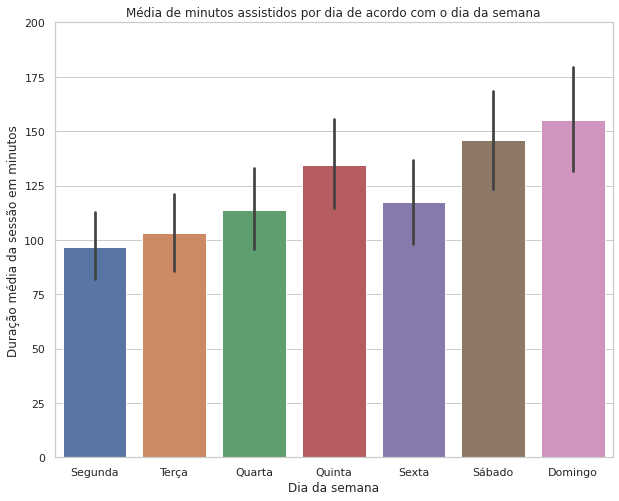

In [28]:
fig = plt.figure(figsize=(10,8))
sns.set_theme(style="whitegrid")
sns.barplot( x='Weekday', y='Duration', data = dt)
plt.ylim(0, 200)
labels = list(map(weekdays.get, by_weekday.index))
plt.xticks(ticks=by_weekday.index , labels=labels)
plt.xlabel('Dia da semana')
plt.ylabel('Duração média da sessão em minutos')
plt.title('Média de minutos assistidos por dia de acordo com o dia da semana')
plt.show()

O tempo médio de acesso por dia da semana mostra que a duração dos acessos cresce no decorrer da semana, com execessão da sexta-feira (#sextou).

### Horários de acesso de acordo com a data

Cada acesso é composto por uma data, horário de início, duração e horário de fim. 

Acessos que iniciam em um dia e terminam em outro foram divididos em dois, um para cada dia, terminando o primeiro as 23:59 e iniciando o segundo as 00:00.

In [29]:
# formatando os dados 

data_plot_time = dataset[['Date', 'Start Time', 'End Time']].copy()
data_plot_time['Date End'] = data_plot_time['End Time'].dt.date
data_plot_time['Minute Start'] = (data_plot_time
                                  .apply(lambda x: x['Start Time'].hour*60 + 
                                         x['Start Time'].minute, axis=1))
data_plot_time['Minute End'] = (data_plot_time
                                  .apply(lambda x: x['End Time'].hour*60 + 
                                         x['End Time'].minute, axis=1))

data_plot_time.drop(['Start Time', 'End Time'], axis=1, inplace=True)

def atualiza_datas(x): 
  data_plot_time.loc[x.name] = [x['Date'], x['Date'], x['Minute Start'], 1439]
  data_plot_time.loc[data_plot_time.shape[0]+1] = [x['Date End'], x['Date End'], 0, x['Minute End']]

data_plot_time[data_plot_time['Minute Start'] > data_plot_time['Minute End']].apply(lambda x: atualiza_datas(x), axis=1)

data_plot_time.drop(data_plot_time[data_plot_time['Minute Start'] == data_plot_time['Minute End']].index, inplace=True)
data_plot_time = data_plot_time.sort_values(by=['Date', 'Minute Start', 'Minute End']).reset_index(drop=True)
data_plot_time['Duration'] = data_plot_time['Minute End'] - data_plot_time['Minute Start']

In [30]:
# labels para plotagem 

y = [200,400,600,1000,1200, 1400]
horas = [str(int(x/60)) for x in y]
minutos = [str(int(x%60)) for x in y]
ylabels = list(zip(horas, minutos))
ylabels = [hora[0]+':'+hora[1] for hora in ylabels]

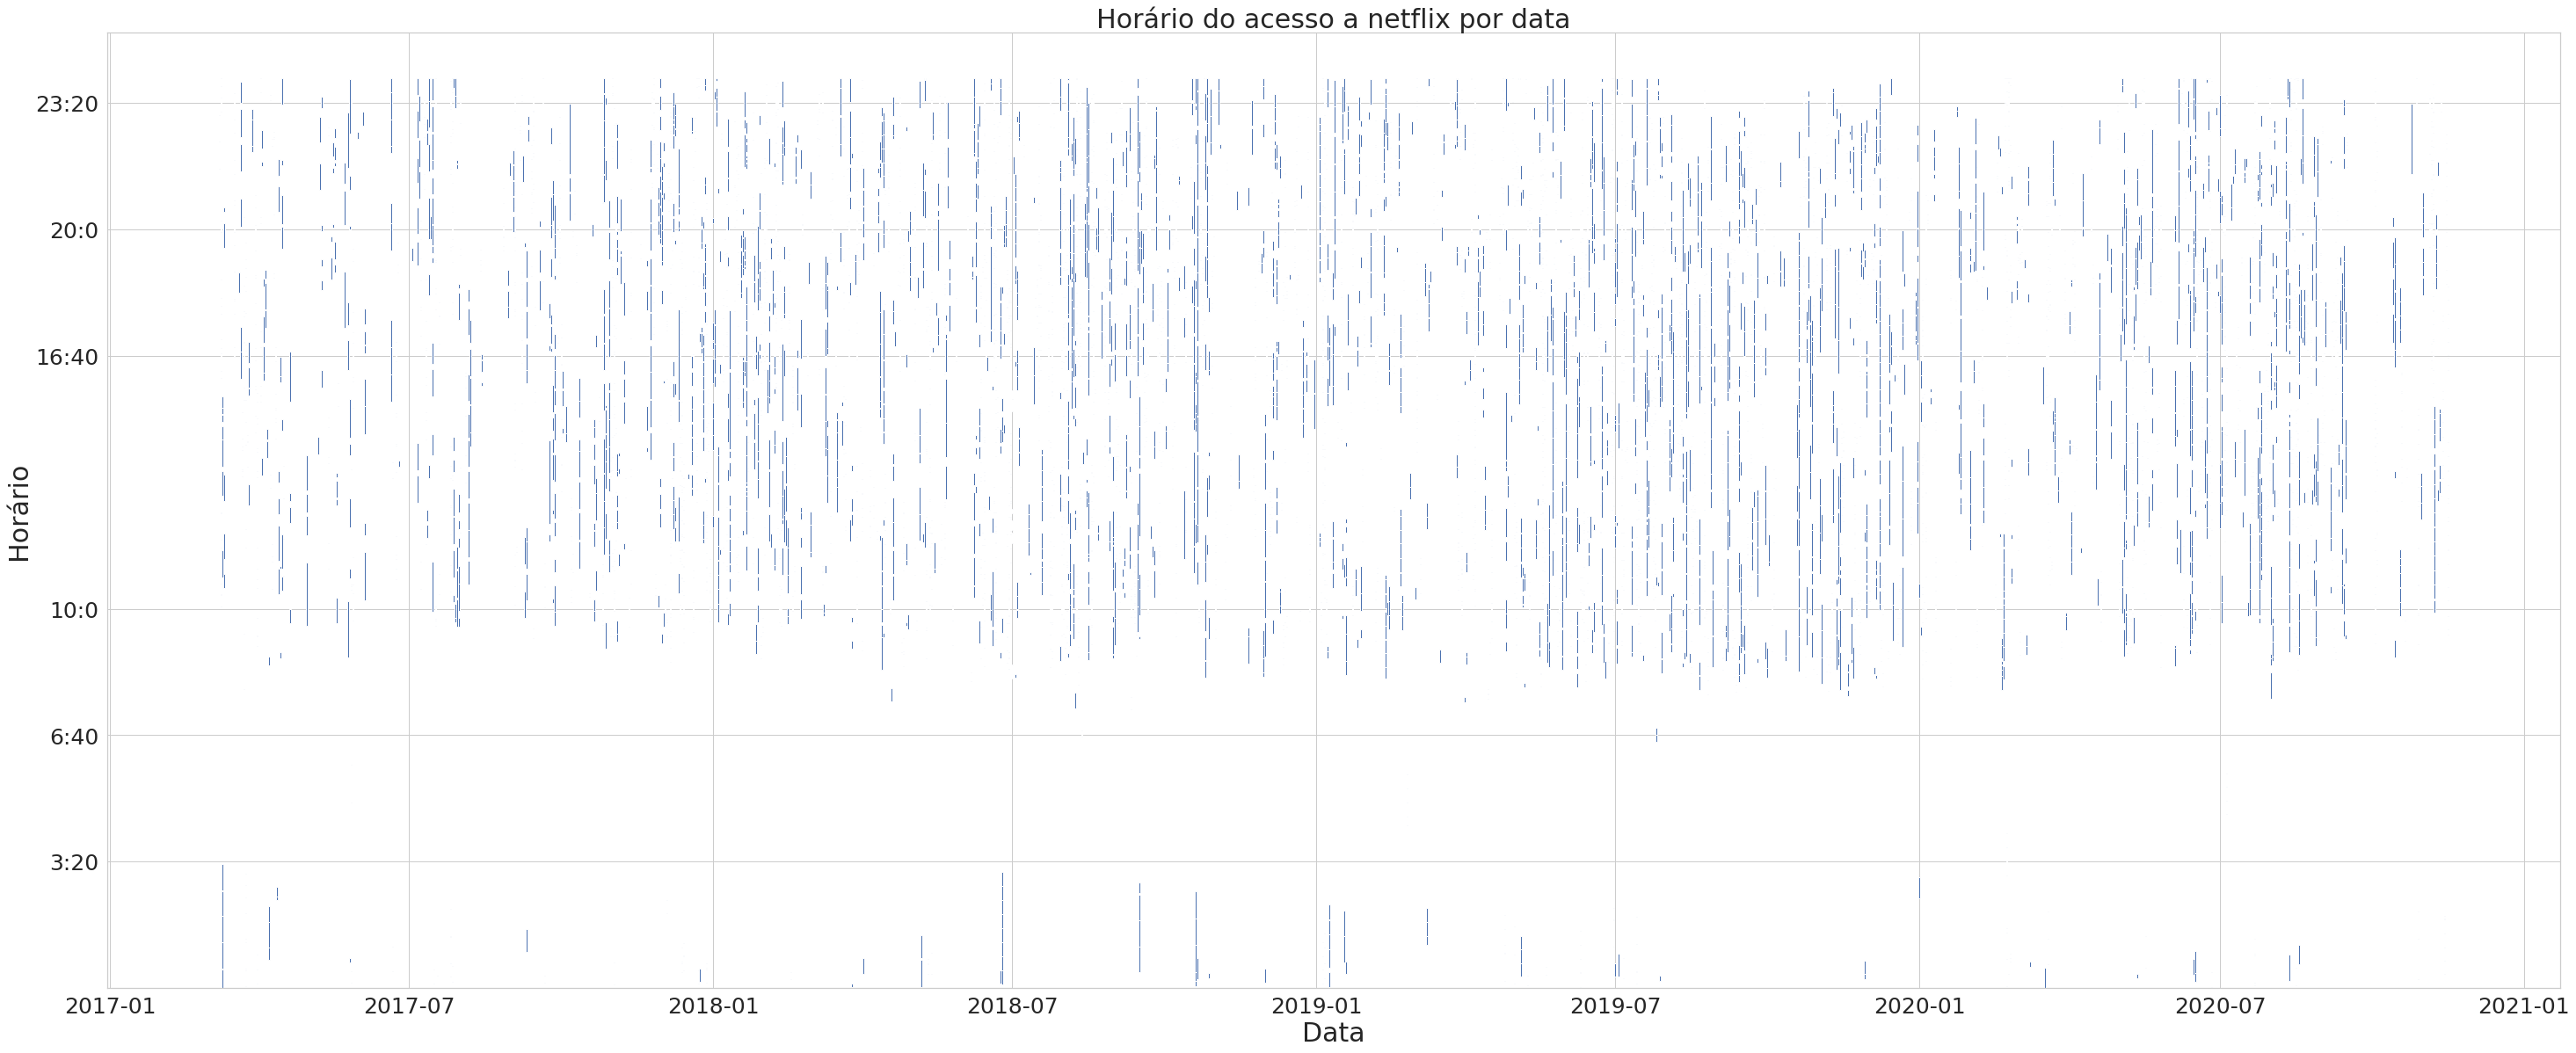

In [31]:
fig = plt.figure(figsize=(50,20))
plt.bar(x = data_plot_time['Date'], 
        height = data_plot_time['Duration'], 
        bottom = data_plot_time['Minute Start'] )
plt.yticks(y, ylabels , fontsize=25)
plt.xticks(fontsize=25)
plt.xlabel('Data', fontsize=30)
plt.ylabel('Horário', fontsize=30)
plt.title('Horário do acesso a netflix por data', fontsize=30)
plt.show()

De acordo com o gráfico, os horários de acesso são bem variados. Não foi possível identificar nenhum padrão.

### Rankeando Séries

In [32]:
series_by_hour = dataset.groupby(['Titulo']).sum()['Duration'].sort_values(ascending=False).head(10)

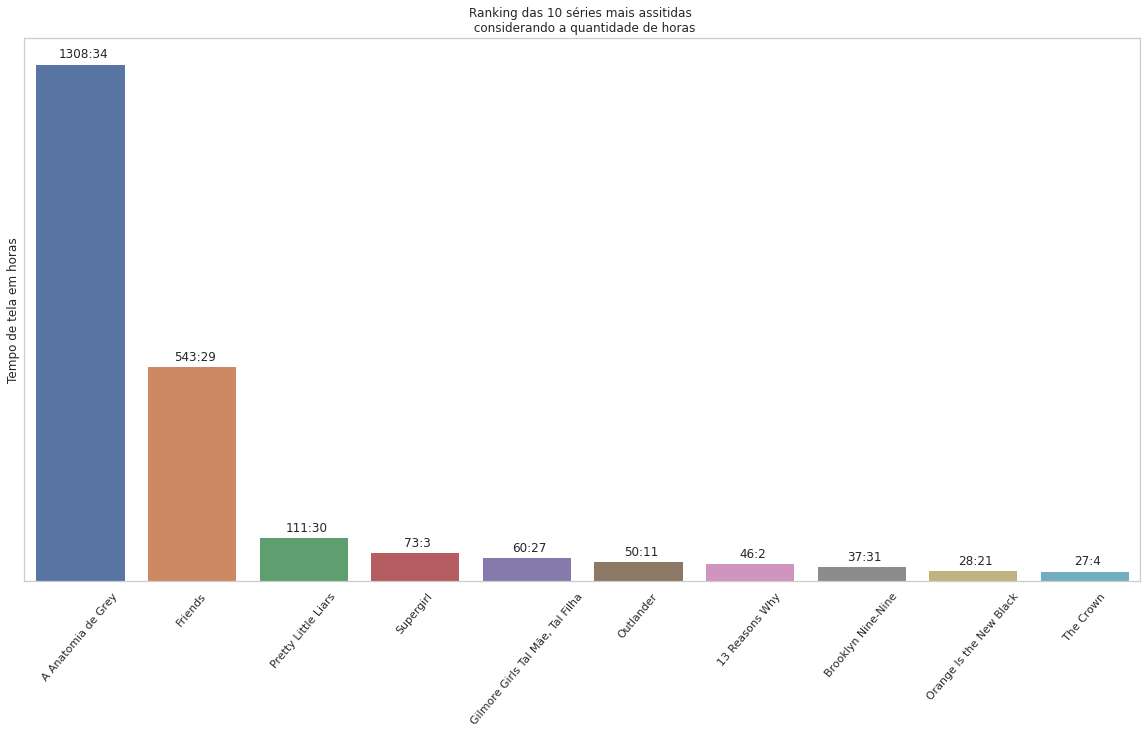

In [33]:
fig = plt.figure(figsize=(20,10))
sns.set_theme(style="whitegrid")
bars = sns.barplot( x=series_by_hour.index, y=series_by_hour.values)
plt.xticks(rotation = 50)
plt.yticks([],[])
plt.xlabel('')
plt.ylabel('Tempo de tela em horas')
plt.title('Ranking das 10 séries mais assitidas \n considerando a quantidade de horas')

for bar in bars.patches:
  height = bar.get_height()
  plt.annotate('{}:{}'.format(int(height/60), int(height%60)),
              xy=(bar.get_x() + bar.get_width() / 2, height),
              xytext=(3, 3),
              textcoords="offset points",
              ha='center', va='bottom')

plt.show()

Aqui a identificação do problema é bem clara: Grey's Anatomy foi assistido por 1308 horas e 34 min, e Friends por 543 horas e 29 minutos. 

Por outro lado, as demais séries assistidas estiveram em execução por no máximo 111 horas e 30 minutos. 

Para todas as demais séries, a quantidade de horas condiz com a extensão da série: Pretty Little Liars tem 160 episódios com média de 40min, enquanto The Crown tem 30 episódios com duração entre 47-60 min. 

Grey's Anatomy tem 363 episódios por volta de 40min cada (242 horas no total), enquanto Friends tem 236 episódios de cerca de 20min (78:40 no total). Logo, as séries poderiam ter sido assistidas 5 e 6 vezes, respectivamente.

### Episódios mais assistidos

Também observamos a lista dos 50 episódios mais assitidos. Episódios das duas séries se intercalam na lista, mas com uma prevalência maior para episódios de Grey's Anatomy: além de serem mais longos, os episódios da série são também mais repetidos.

In [34]:
count_viwes = dataset.groupby(['Titulo', 'Temporada', 'Episodio'])['Date'].agg(['count'])
count_viwes.sort_values('count', ascending=False).head(50)

count
Titulo             Temporada     Episodio                                                 
A Anatomia de Grey  Temporada 7   Casamento informal (Episódio 20)                      20
                    Temporada 6   Morte e companhia (Episódio 24)                       17
                    Temporada 8   Disfarçando (Episódio 6)                              17
                                  Tempo ruim (Episódio 22)                              17
                    Temporada 6   Invasão (Episódio 5)                                  16
                                  Festas de fim de ano (Episódio 10)                    16
                                  Bom luto (Episódio 1)                                 16
                    Temporada 10  Quero você comigo (Episódio 2)                        15
                    Temporada 6   Todo mundo quer ser feliz (Episódio 22)               15
                    Temporada 7   Algo tem que dar certo (Episódio 8)                   15
                    Temporada 8   Escura era a noite (Episódio 9)                       15
                    Temporada 7   Esquisitíssimo (Episódio 3)                           15
                    Temporada 8   Entrando no jogo (Episódio 7)                         15
                    Temporada 11  Tem que ser para valer (Episódio 3)                   15
                    Temporada 7   Sou eu tentando (Episódio 7)                          15
                    Temporada 11  O próximo passo (Episódio 9)                          14
                    Temporada 6   Uma questão de ponto de vista (Episódio 6)            14
                                  Obrigação dolorosa (Episódio 4)                       14
                                  Massacre do dia dos namorados (Episódio 14)           14
Friends             Temporada 7   Aquele com a prima da Monica e do Ross (Episód...     14
A Anatomia de Grey  Temporada 9   Monstro adormecido (Episódio 21)                      14
                    Temporada 5   Que diferença um dia faz (Episódio 22)                14
                    Temporada 6   Sem máscaras (Episódio 12)                            14
                    Temporada 12  Quebra de rotina (Episódio 13)                        14
                    Temporada 9   Sentimentos persistentes (Episódio 19)                14
                    Temporada 13  Não é da sua conta (Episódio 12)                      14
                    Temporada 8   De repente (Episódio 10)                              14
                    Temporada 9   Belo apocalipse (Episódio 5)                          13
                    Temporada 6   Cada um por si (Episódio 20)                          13
                    Temporada 8   Só precisamos de amor (Episódio 14)                   13
Friends             Temporada 7   Aquele do vestido de noiva barato (Episódio 17)       13
A Anatomia de Grey  Temporada 9   Mãos ociosas (Episódio 18)                            13
                                  Ela está me matando (Episódio 20)                     13
                    Temporada 13  E só vai piorar (Episódio 13)                         13
                    Temporada 8   Queda livre (Episódio 1)                              13
                                  Migração (Episódio 23)                                13
                                  Amor, perda e legado (Episódio 5)                     13
                    Temporada 7   Desarmar (Episódio 11)                                13
                                  Menor desacompanhada (Episódio 22)                    13
                                  É assim que a gente faz (Episódio 17)                 13
                                  Com você, nasci de novo (Episódio 1)                  13
                                  Chegando a hora (Episódio 15)                         13
                                  Noites em claro, nunca mais (Episódio 9)       

*nota* : a base de dados considera como uma exibição cada vez que o episódio é assistido, independente de ser concluído ou não.

### Friends

In [35]:
friends = dataset[dataset['Titulo']=='Friends'].copy()
friends.loc[:,'Temporada'] = friends.apply(lambda x: x.Temporada.split(' ')[2], axis=1)
friends['episodio'] = friends.apply(lambda x: x.Episodio.split('(')[0], axis=1)
friends['#episodio'] = friends.apply(lambda x: x.Episodio.split('(')[1].split(')')[0].split(' ')[1], axis=1)

In [36]:
ranking_friends = (friends.
                   groupby(['Temporada', '#episodio', 'episodio'])['Duration'].
                   agg(['count']).
                   reset_index().
                   astype({'Temporada': 'int64', '#episodio': 'int64', 'count': 'int64'}).
                   sort_values(by=['Temporada', '#episodio'], ascending=[True, True])
                   )
ranking_friends.reset_index(drop=True, inplace=True)

#### Frequência com que cada episódio foi assistido

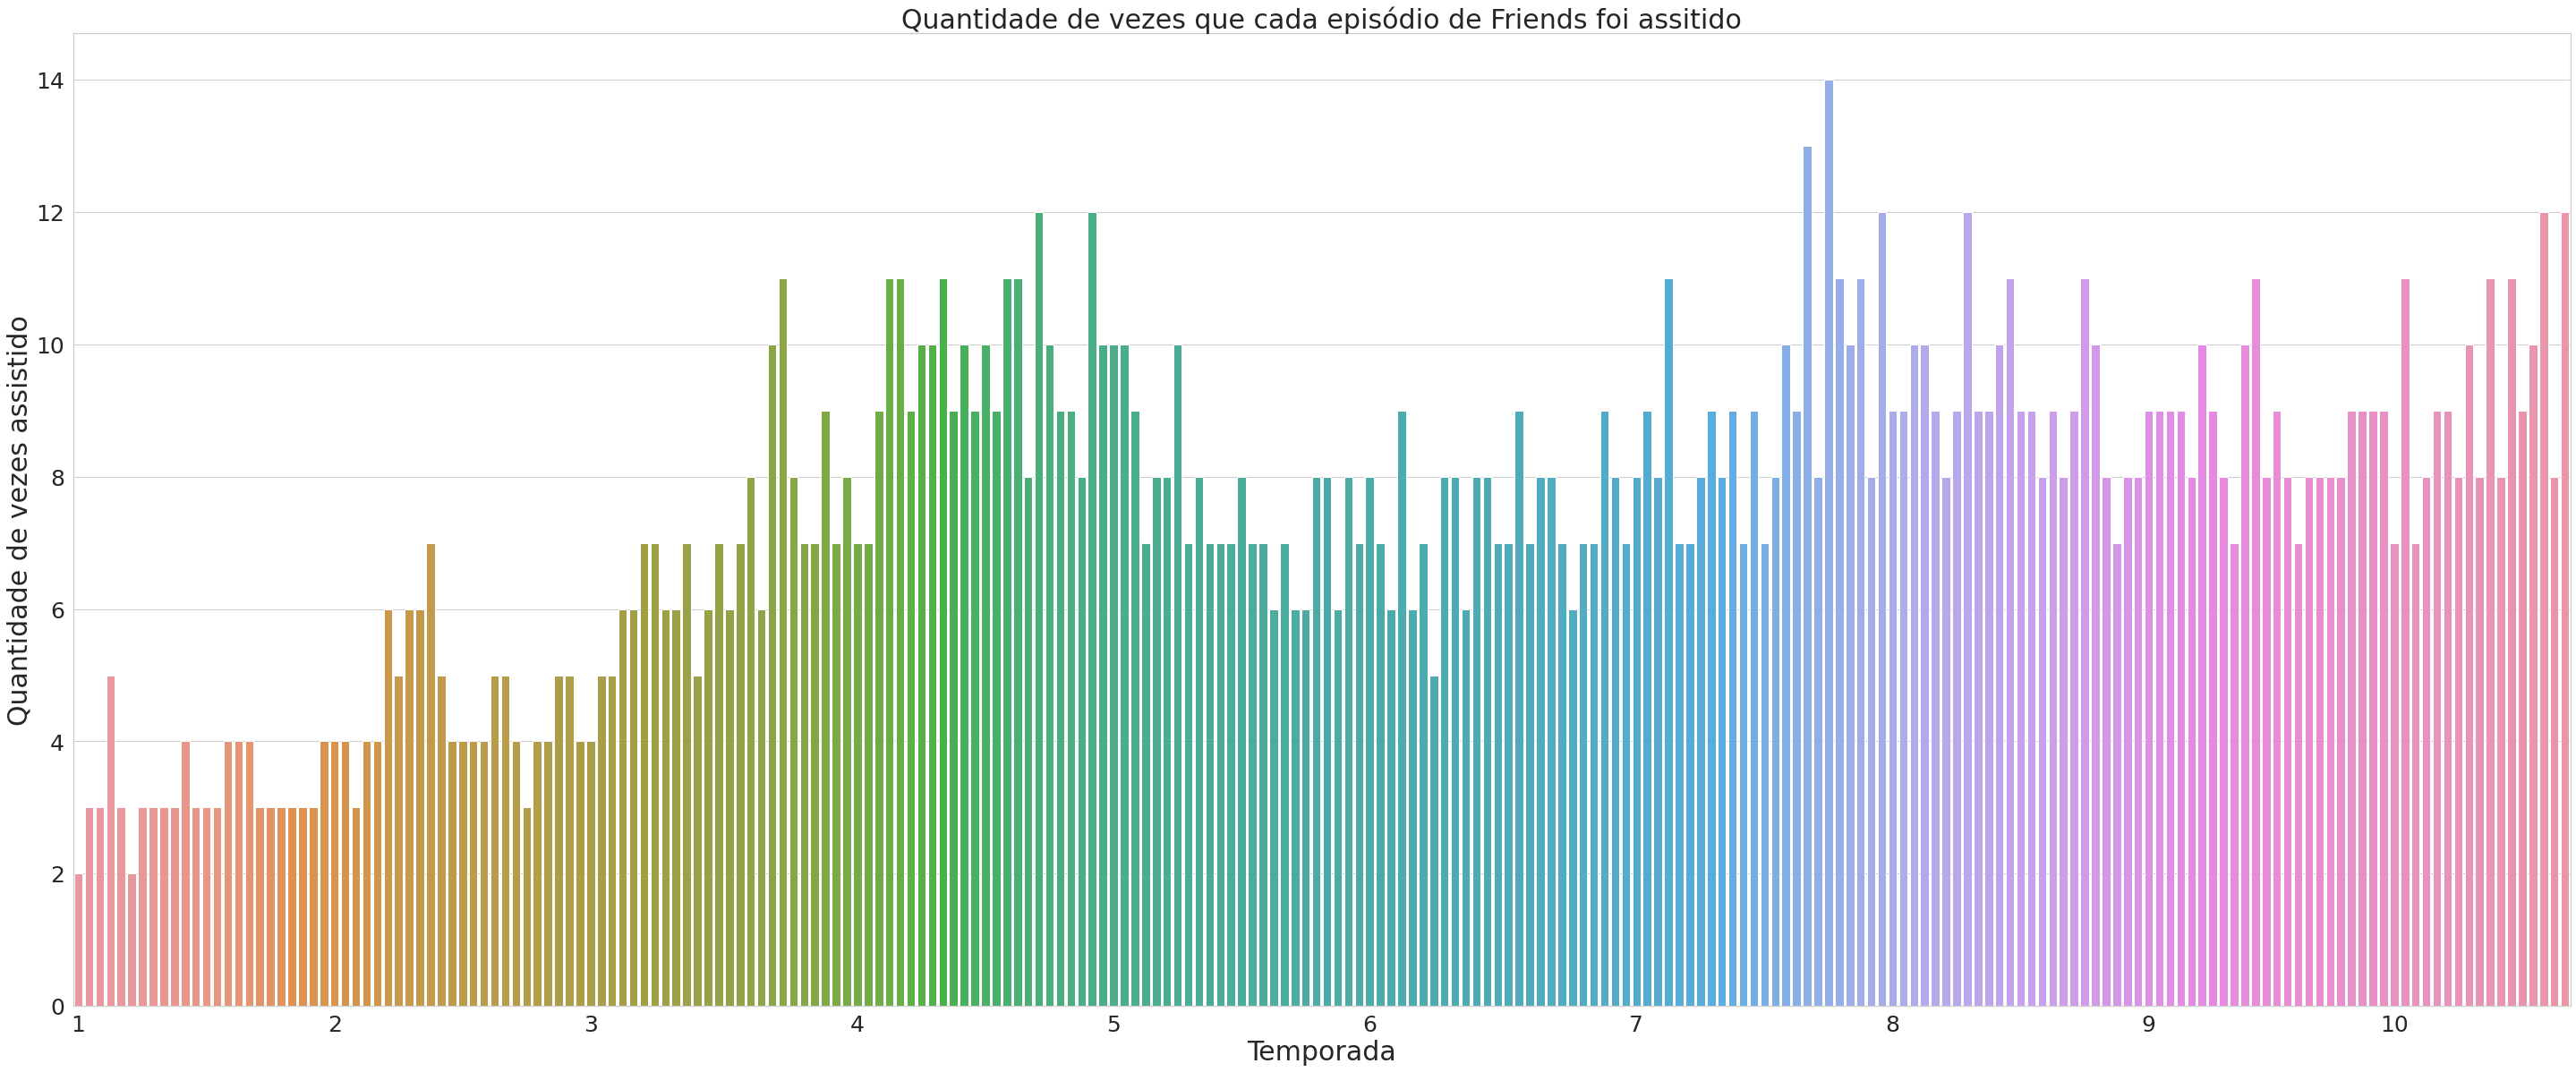

In [37]:
labels = ranking_friends[ranking_friends['#episodio']==1]['Temporada']

figure = plt.figure(figsize=(50, 20))
sns.barplot(x=ranking_friends.index, 
            y = 'count',
            data=ranking_friends)
plt.xticks(labels.index, labels.values, fontsize= 25)
plt.yticks(fontsize= 25)
plt.xlabel('Temporada', fontsize= 30)
plt.ylabel('Quantidade de vezes assistido', fontsize= 30)
plt.title('Quantidade de vezes que cada episódio de Friends foi assitido', fontsize= 30)
plt.show()

O gráfico mostra a frequência com que cada episódio da série foi assitido. 
Destaca-se o máximo de 14 visualizações em um episódio da 7ª temporada e o mínimo de 2 visualizações em 2 episódios da 1ª temporada. 

Também é possível perceber a preferência por algumas temporadas: na 1ª, a frequência das visulizações varia de 2 a 5; enquanto nas últimas temporadas (a partir da 7ª) esses números mudam para 7 e 14.

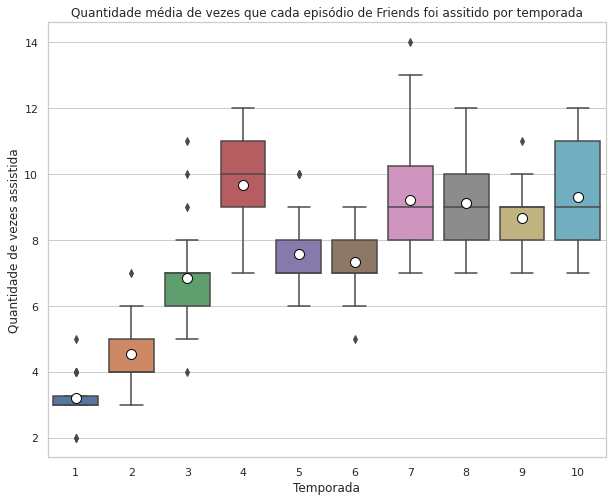

In [38]:
figure = plt.figure(figsize=(10,8))
sns.set_theme(style="whitegrid")
sns.boxplot(x='Temporada', y='count', data = ranking_friends,
            showmeans=True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                       "markersize":"10"})
plt.xlabel('Temporada')
plt.ylabel('Quantidade de vezes assistida')
plt.title('Quantidade média de vezes que cada episódio de Friends foi assitido por temporada')
plt.show()

O boxplot confirma as análises: os episódios da 4ª temporada e das temporadas finais da séries (7-10) foram mais exibidos, com média acima de 8 vezes. 



#### Conclusões

Eu assisti a série inteira 2 vezes, ou 3 se desconsiderar os episódios S1E1 e S1E6 (esse problema já está sendo resolvido). 

Eu tenho preferência pela 4ª temporada e pelas últimas (7-10). Nessas temporadas eu assisti cada episódio mais de 8 vezes.

A primeira e a segunda temporada são as menos assistidas (e olha que eu gosto delas).


### Grey's Anatomy

In [39]:
greys = dataset[dataset['Titulo']=='A Anatomia de Grey'].copy()
greys.loc[:,'Temporada'] = greys.apply(lambda x: x.Temporada.split(' ')[2], axis=1)
greys['episodio'] = greys.apply(lambda x: x.Episodio.split('(')[0], axis=1)
greys['#episodio'] = greys.apply(lambda x: x.Episodio.split('(')[-1].split(')')[0].split(' ')[1], axis=1)

In [40]:
ranking_greys = (greys.
                 groupby(['Temporada', '#episodio', 'episodio'])['Duration'].
                 agg(['count']).
                 reset_index().
                 astype({'Temporada': 'int64', '#episodio': 'int64', 'count': 'int64'}).
                 sort_values(['Temporada', '#episodio'], ascending=[True, True]).
                 reset_index(drop=True)
                 )

#### Frequência com que cada episódio foi assistido

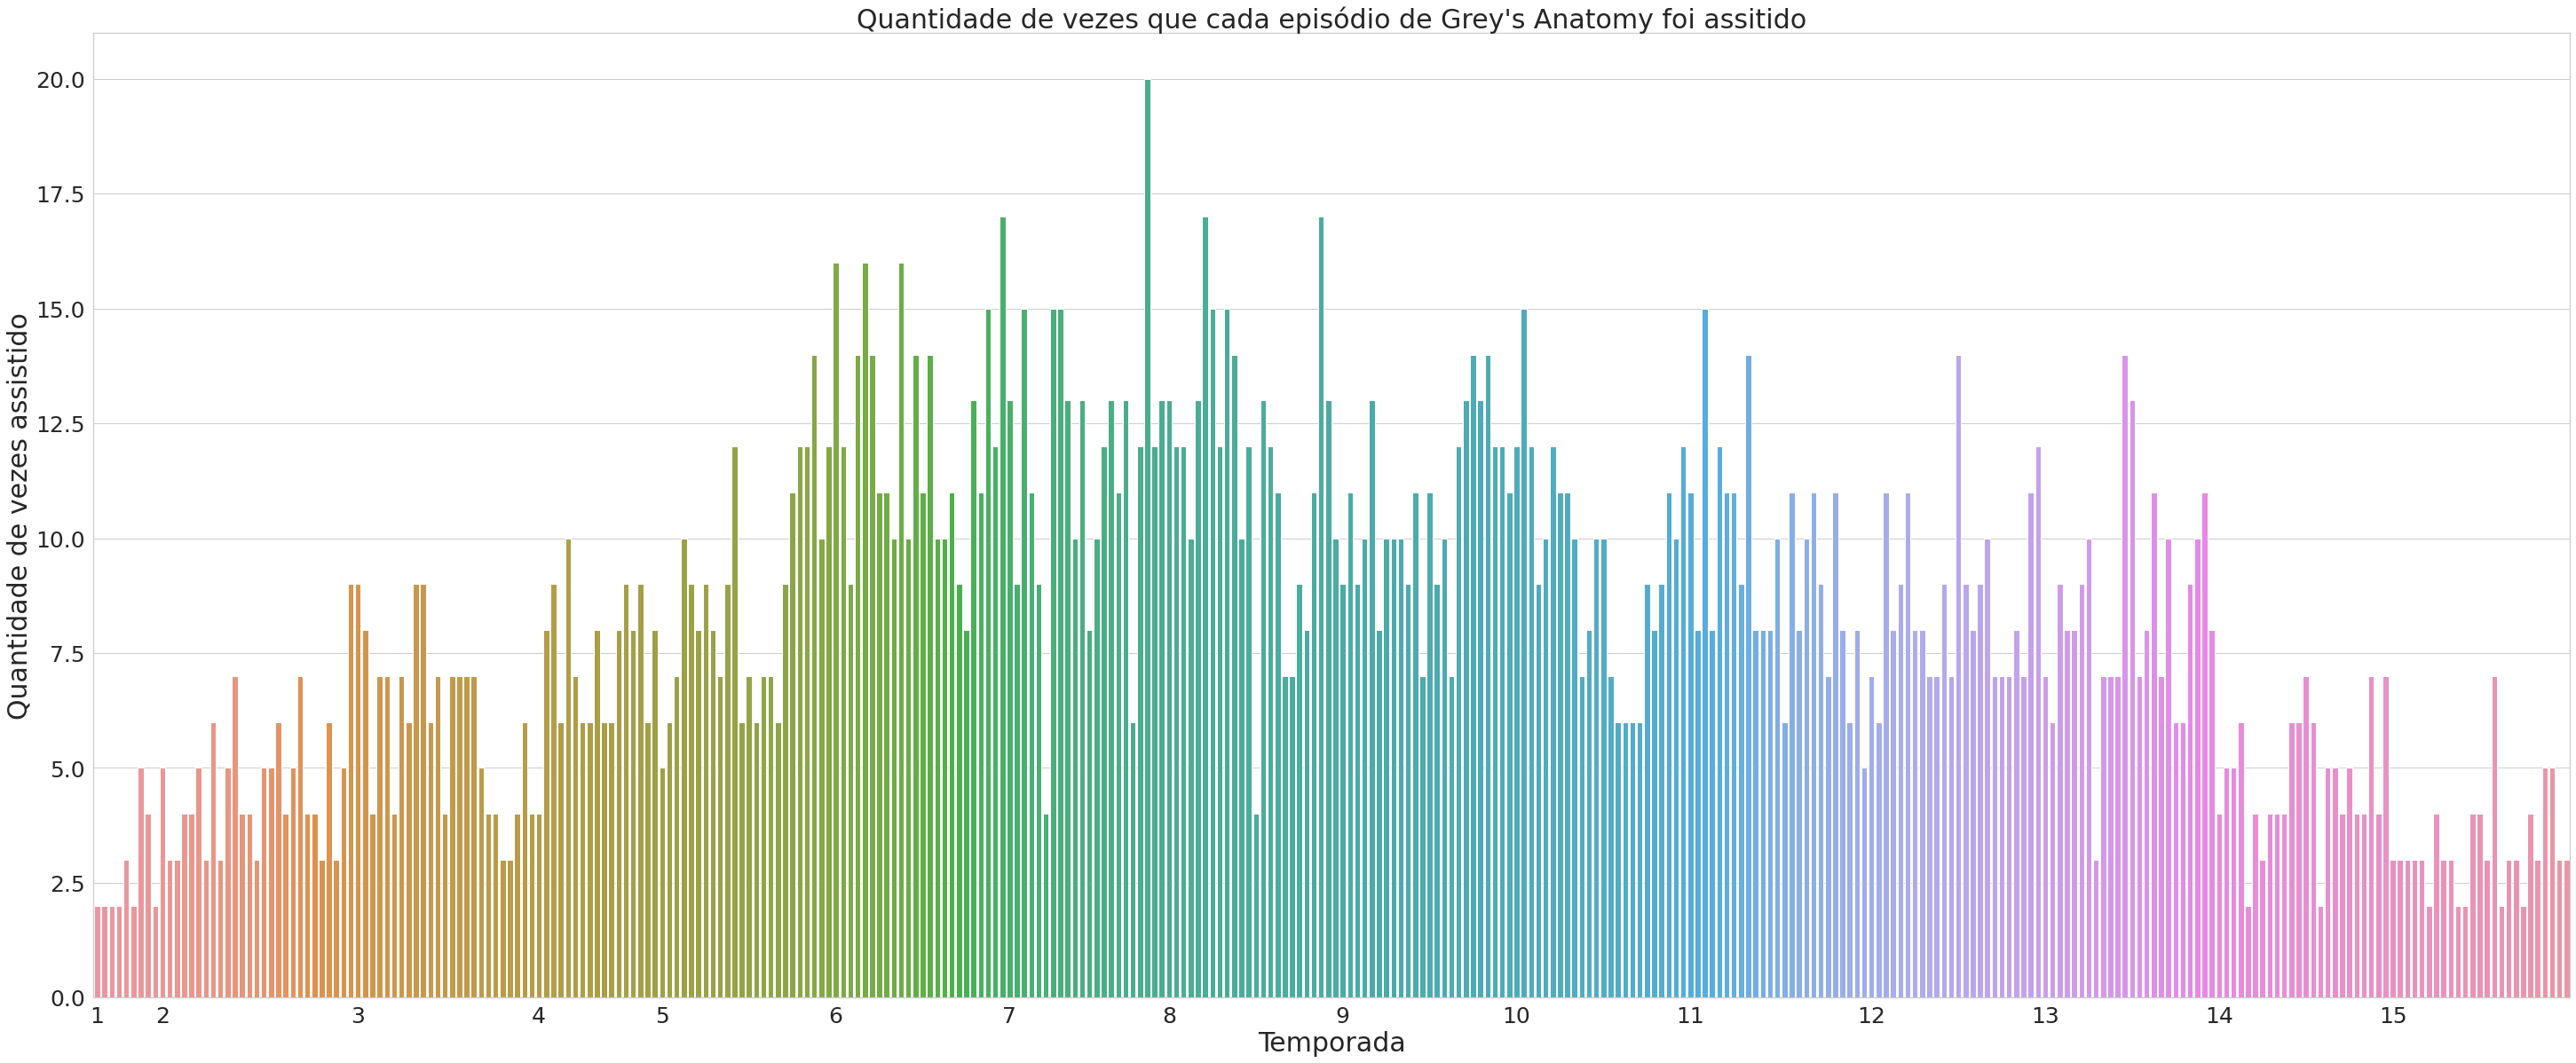

In [41]:
labels = ranking_greys[ranking_greys['#episodio']==1]['Temporada']

figure = plt.figure(figsize=(50,20))
sns.barplot(x=ranking_greys.index, 
            y = 'count',
            data=ranking_greys)
plt.xticks(labels.index, labels.values, fontsize= 25)
plt.yticks(fontsize= 25)
plt.xlabel('Temporada', fontsize= 30)
plt.ylabel('Quantidade de vezes assistido', fontsize= 30)
plt.title("Quantidade de vezes que cada episódio de Grey's Anatomy foi assitido",
          fontsize= 30)
plt.show()

De mesmo modo, analisamos a frequência com que cada episódio de Grey's Anatomy foi assitido. 

Aqui destacam-se: o máximo de 20 exibições para um epispódio na 7ª temporada (o episódio do Post-it <3), e o mínimo de 2 exibições em episódios variados na 1ª, 14ª e 15ª temporadas.

Também nota-se a preferência por episódios das temporadas intermediárias.

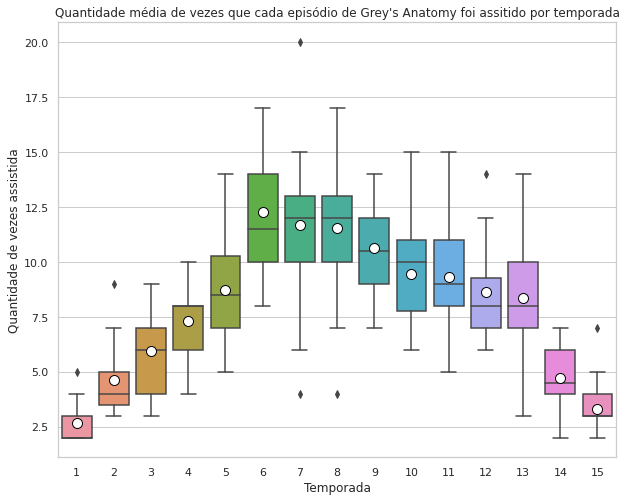

In [42]:
figure = plt.figure(figsize=(10,8))
sns.set_theme(style="whitegrid")
sns.boxplot(x='Temporada', y='count', data = ranking_greys, 
            showmeans=True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.xlabel('Temporada')
plt.ylabel('Quantidade de vezes assistida')
plt.title("Quantidade média de vezes que cada episódio de Grey's Anatomy foi assitido por temporada")
plt.show()

O boxplot descreve melhor essa tendência: as temporadas 6 a 9 tem média de exibição acima de 10 vezes! 

Essa média diminui conforme aproxima-se o início ou  final na série.

#### Conclusões

Eu assisti todos os episódios pelo menos 2 vezes. 

Eu tenho preferência pelas temporadas intermediárias, entre a 6 e a 9. Nessas temporadas eu assiti cada episódio uma média de 10 vezes, chegando ao absurdo de assistir  20 vezes o episódio do Post-it <3 (S7E20).


## E se eu fosse uma pessoa normal?



In [43]:
select = (dataset['Titulo']=='Friends') | (dataset['Titulo']=='A Anatomia de Grey')
other_series = dataset[~select].copy()

### Frequência de uso da netflix por data

In [44]:
# minutos assitidos por dia
other_series_by_date = other_series.groupby(other_series['Date']).sum()['Duration']

#considerando os dias em que a contagem foi zero
min_date, max_date = other_series['Date'].min(), other_series['Date'].max()
all_dates = pd.date_range(start = min_date, end = max_date)
data_by_dates = pd.Series(data = np.zeros(all_dates.shape[0]), index = all_dates, name = 'Duration' )

data_by_dates = pd.merge(data_by_dates, other_series_by_date, how='left', left_index=True, right_index= True)
data_by_dates['Duration'] = data_by_dates['Duration_x'] + data_by_dates['Duration_y']
data_by_dates = (data_by_dates.
                 drop(['Duration_x', 'Duration_y'], axis=1).
                 fillna(0).
                 reset_index()
                 )
data_by_dates['Weekday'] = data_by_dates['index'].dt.dayofweek

In [45]:
#labels 
data_by_dates['labels'] = data_by_dates['index'].dt.to_period('M')
x_ticks = data_by_dates['labels'].searchsorted(data_by_dates['labels'].unique())
data_by_dates.drop('labels', axis=1, inplace=True)
x_labels = data_by_dates.loc[x_ticks, 'index'].dt.to_period('M')

y_ticks = [100,200,300,400,500,600,700,800]
hours = [str(int(x/60)) for x in y_ticks]
minutes = [str(int(x%60)) for x in y_ticks]
y_labels = list(zip(hours, minutes))
y_labels = [hour[0]+':'+hour[1] for hour in y_labels]

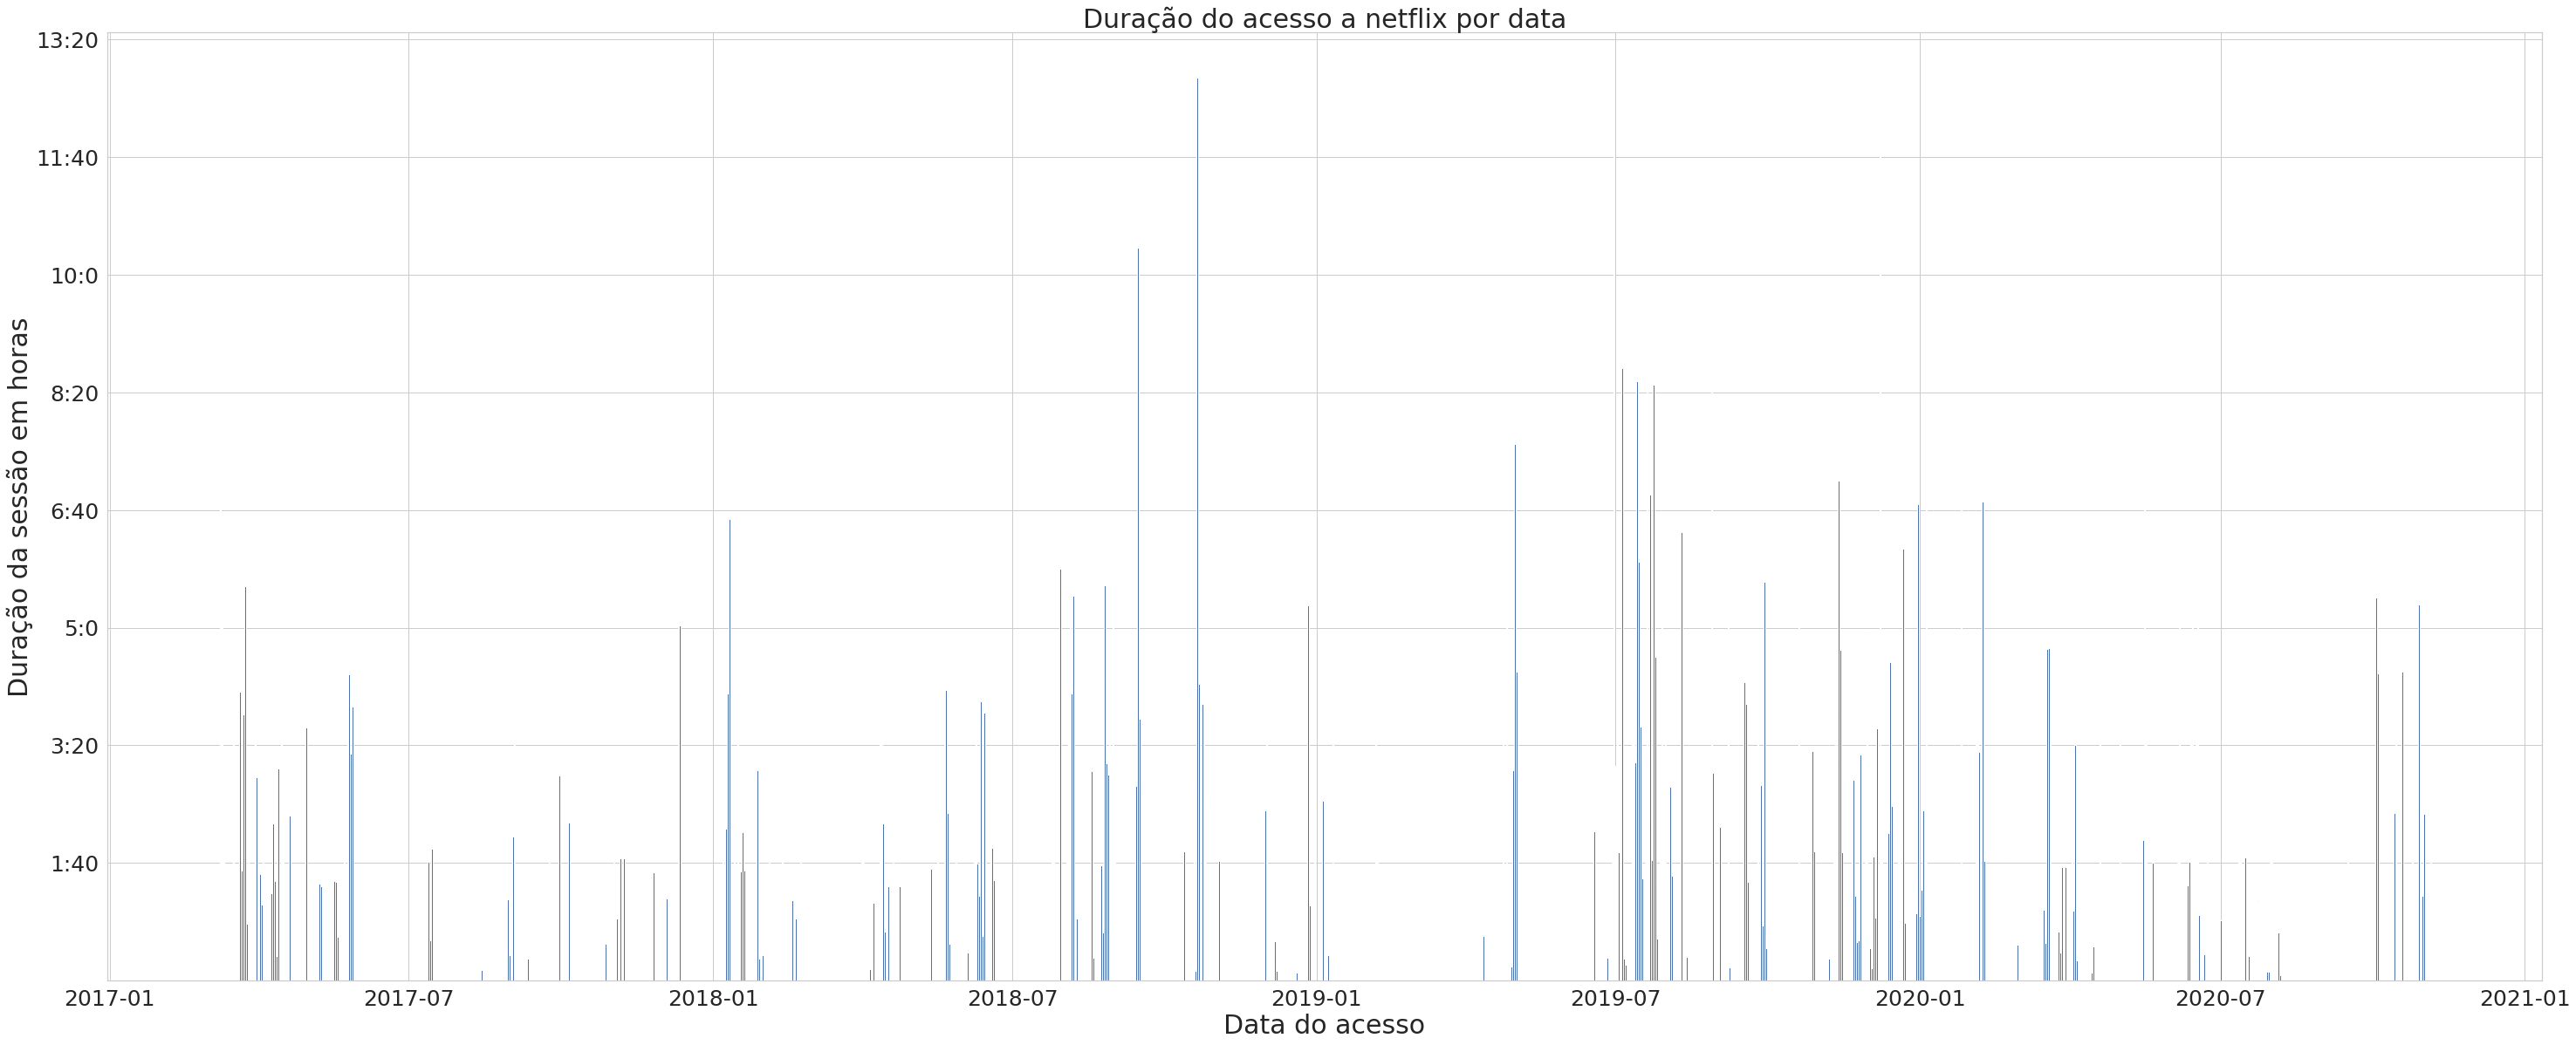

In [46]:
fig = plt.figure(figsize=(50,20))
plt.bar(x = data_by_dates['index'],
        height = data_by_dates['Duration'])
plt.xticks(fontsize=25)
plt.yticks(y_ticks, y_labels, fontsize=25)
plt.xlabel('Data do acesso', fontsize=30)
plt.ylabel('Duração da sessão em horas', fontsize=30)
plt.title('Duração do acesso a netflix por data', fontsize=30)

plt.show()

Desconsiderando as duas séries, eu sou uma pessoa normal! haha 

O consumo de netflix reduz bastante em relação ao tempo, mas ainda há picos. Nesses dias, em geral, eu maratonei uma série só o dia todo. (Tabela abaixo) 

Um intervalo legal de notar: no início de 2019 eu entrei no mestrado, nessa época há uma baixa considerável no gráfico,  até as férias em Julho onde tem um pico. Nesse período eu paguei as disciplinas presenciais, logo, menos netflix. 

In [48]:
max_acessos = data_by_dates.sort_values('Duration', ascending=False).head(10)['index'].dt.date
max_acessos = (other_series[other_series['Date'].isin(max_acessos)].
               groupby(['Date', 'Weekday', 'Titulo'])['Duration'].
               agg({'sum'}))
max_acessos.loc[:, 'sum'] = max_acessos.apply(lambda x: str(int(x['sum']/60))+':'+str(int(x['sum']%60)), axis=1)
max_acessos.columns = ['Duration']
max_acessos

,,,Duration
Date,Weekday,Titulo,
2018-09-15,5,Supergirl,10:22
2018-10-21,6,Outlander,12:47
2019-06-30,6,Pretty Little Liars,12:47
2019-07-05,4,Pretty Little Liars,8:40
2019-07-14,6,Pretty Little Liars,8:29
2019-07-20,5,Pretty Little Liars,8:30
2019-07-24,2,Pretty Little Liars,8:26
2019-08-28,2,13 Reasons Why,8:49
2019-12-08,6,Brooklyn Nine-Nine,11:42


### Duração média de acesso

In [49]:
print('A duração média de acesso, que era de 2 horas e 3 minutos, cai para {} horas e {} minutos. '.format(int(dt['Duration'].mean()/60), int(dt['Duration'].mean()%60)))

A duração média de acesso, que era de 2 horas e 3 minutos, cai para 2 horas e 3 minutos. 


### Tempo total gasto assistindo outras séries

In [50]:
minutos = other_series['Duration'].sum()
horas = minutos/60
dias = horas/24
print('O tempo de tela total, que era de 116 dias 1 hora e 45 minutos,'+
      ' também reduz bastante, para '+
      '{} dias {} horas e {} minutos'.format(int(dias),
                                             int(horas)-24*int(dias),
                                             int(minutos)-60*(24*int(dias) + (int(horas)-24*int(dias)))
                                             )
      )

O tempo de tela total, que era de 116 dias 1 hora e 45 minutos, também reduz bastante, para 38 dias 21 horas e 41 minutos


### Variação da duração dos acessos de acordo com os dias da semana

In [51]:
by_weekday = data_by_dates.groupby('Weekday').mean()

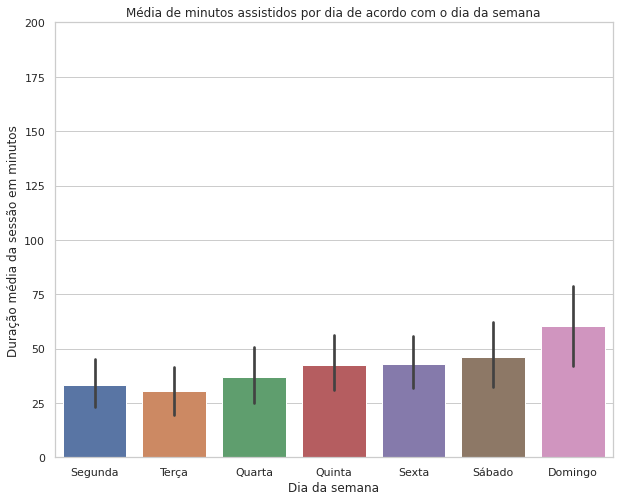

In [52]:
fig = plt.figure(figsize=(10,8))
sns.set_theme(style="whitegrid")
sns.barplot( x='Weekday', y='Duration', data = data_by_dates)
plt.ylim(0, 200)
labels = list(map(weekdays.get, by_weekday.index))
plt.xticks(ticks=by_weekday.index , labels=labels)
plt.xlabel('Dia da semana')
plt.ylabel('Duração média da sessão em minutos')
plt.title('Média de minutos assistidos por dia de acordo com o dia da semana')
plt.show()

Na distribuição durante a semana, percebe-se tanto a redução de maneira geral, quanto a redução considerável nos dias úteis.

### Horários de acesso de acordo com a data

In [53]:
data_plot_time = other_series[['Date', 'Start Time', 'End Time']].copy()
data_plot_time['Date End'] = data_plot_time['End Time'].dt.date
data_plot_time['Minute Start'] = (data_plot_time
                                  .apply(lambda x: x['Start Time'].hour*60 + 
                                         x['Start Time'].minute, axis=1))
data_plot_time['Minute End'] = (data_plot_time
                                  .apply(lambda x: x['End Time'].hour*60 + 
                                         x['End Time'].minute, axis=1))

data_plot_time.drop(['Start Time', 'End Time'], axis=1, inplace=True)

def atualiza_datas(x): 
  data_plot_time.loc[x.name] = [x['Date'], x['Date'], x['Minute Start'], 1439]
  data_plot_time.loc[data_plot_time.shape[0]+1] = [x['Date End'], x['Date End'], 0, x['Minute End']]

data_plot_time[data_plot_time['Minute Start'] > data_plot_time['Minute End']].apply(lambda x: atualiza_datas(x), axis=1)

data_plot_time.drop(data_plot_time[data_plot_time['Minute Start'] == data_plot_time['Minute End']].index, inplace=True)
data_plot_time = data_plot_time.sort_values(by=['Date', 'Minute Start', 'Minute End']).reset_index(drop=True)
data_plot_time['Duration'] = data_plot_time['Minute End'] - data_plot_time['Minute Start']

In [54]:
y = [200,400,600,1000,1200, 1400]
horas = [str(int(x/60)) for x in y]
minutos = [str(int(x%60)) for x in y]
ylabels = list(zip(horas, minutos))
ylabels = [hora[0]+':'+hora[1] for hora in ylabels]

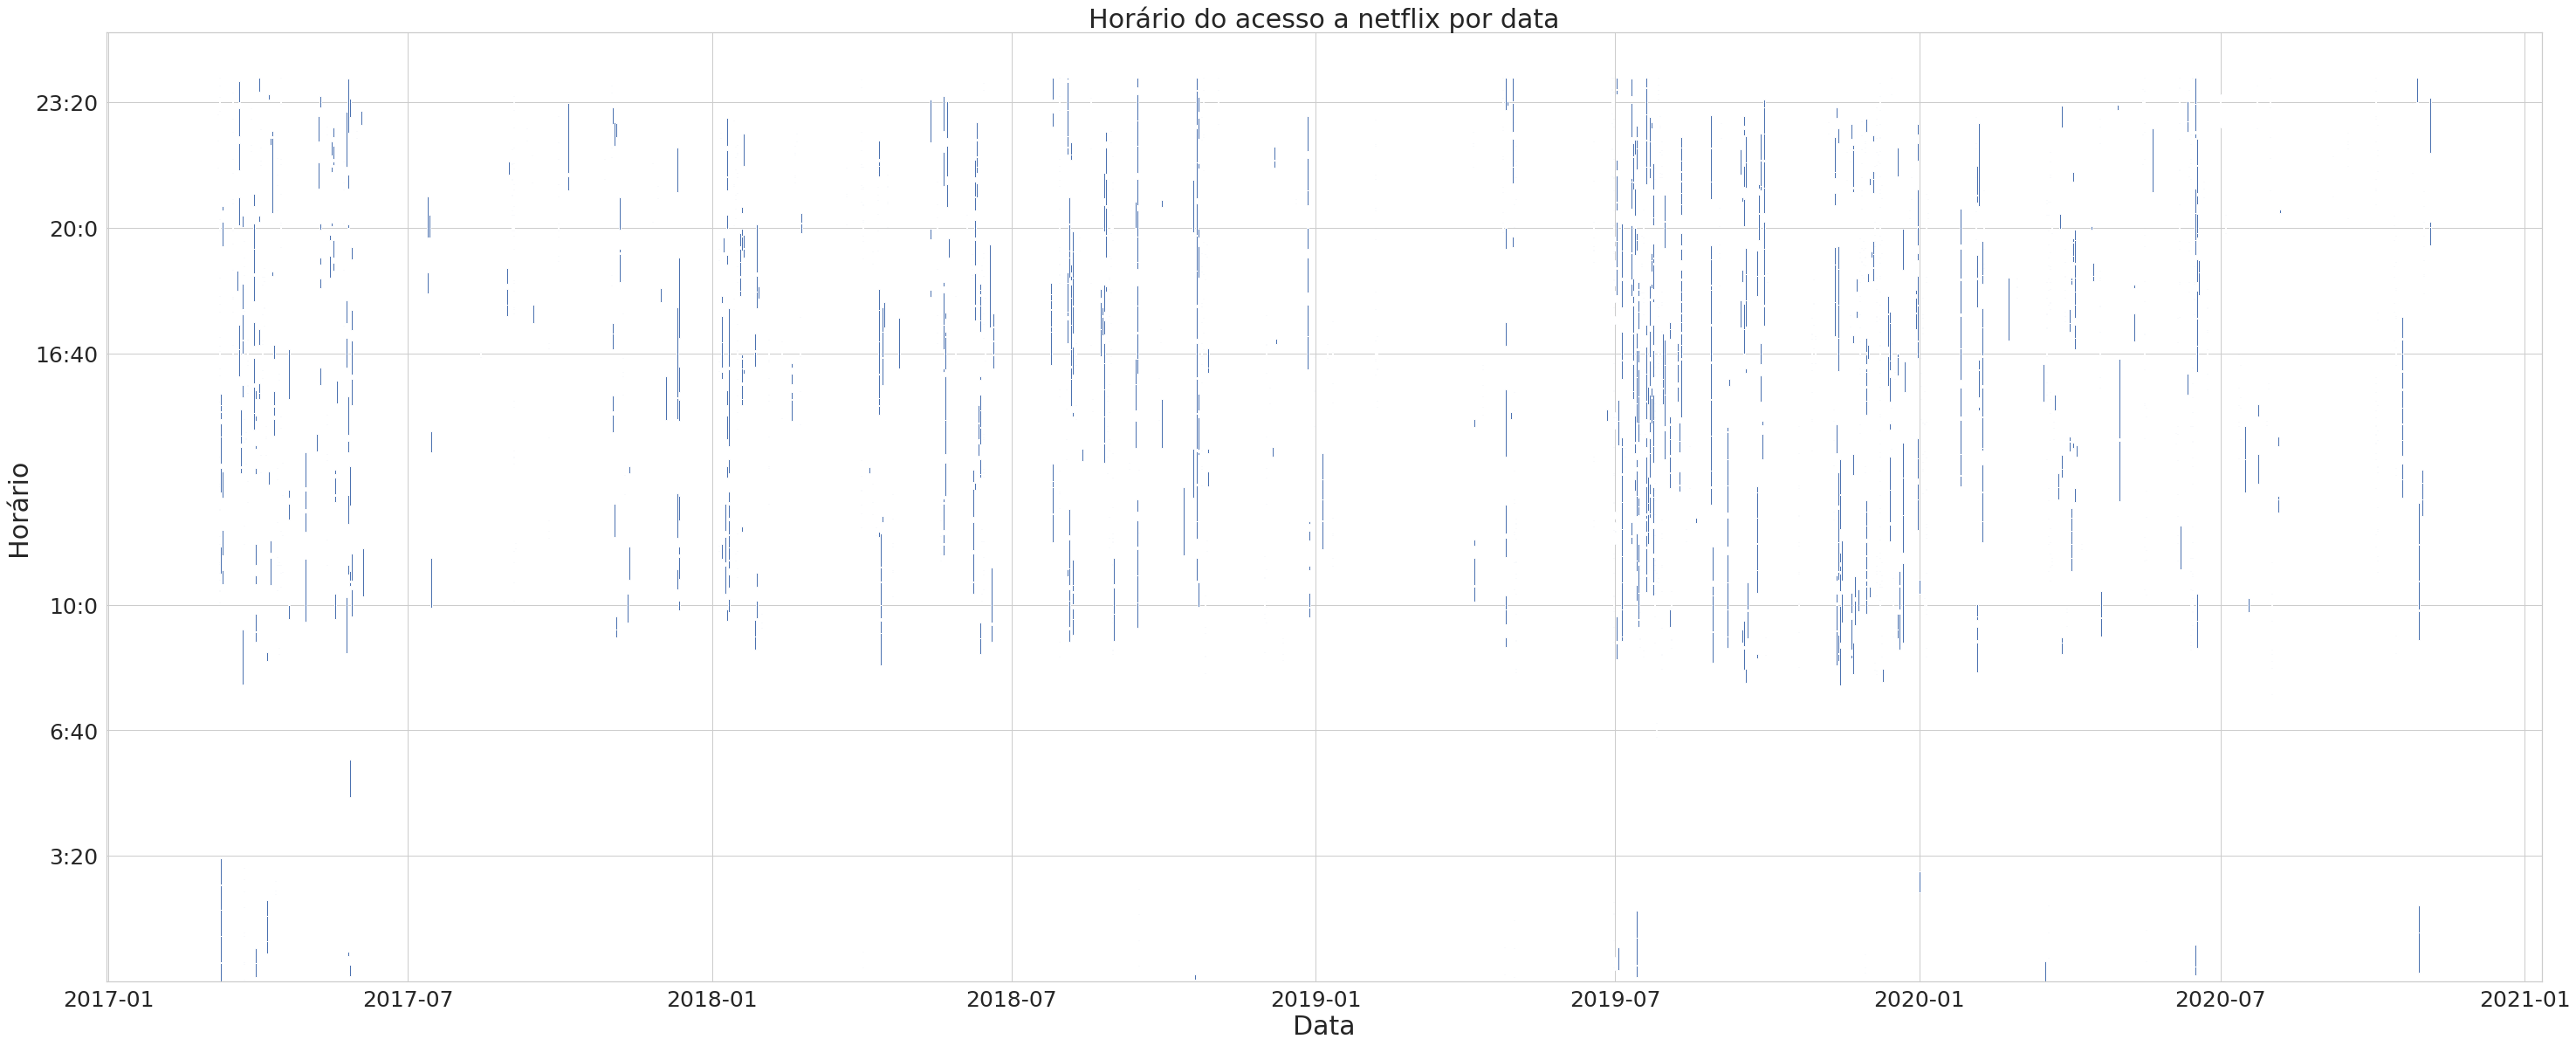

In [55]:
fig = plt.figure(figsize=(50,20))
plt.bar(x = data_plot_time['Date'], 
        height = data_plot_time['Duration'], 
        bottom = data_plot_time['Minute Start'] )
plt.yticks(y, ylabels , fontsize=25)
plt.xticks(fontsize=25)
plt.xlabel('Data', fontsize=30)
plt.ylabel('Horário', fontsize=30)
plt.title('Horário do acesso a netflix por data', fontsize=30)
plt.show()

Quanto ao horário, continua bastande distribuído, de modo que não é possível tirar conclusões.